In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

2022-10-30 20:52:33.439104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 20:52:33.539280: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-30 20:52:34.009089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-30 20:52:34.009126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
tf.config.experimental.list_physical_devices()

2022-10-30 20:52:35.036653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-10-30 20:52:35.041651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 20:52:35.042193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Setup

In [3]:
# ! conda env create --file=environment.yml
# ! pip install requirements.txt


In [4]:
"""
uncomment this if running this for the first time
"""
# ! mkdir ~/.kaggle
# ! kaggle competitions download -c higgs-boson 
# ! unzip higgs-boson.zip -d higgs-boson
# ! unzip ./higgs-boson/training.zip -d ./higgs-boson/training/
# ! ls ./higgs-boson/training

'\nuncomment this if running this for the first time\n'

## Preprocessing

In [5]:
"""
Let's read the training csvs

"""
import pandas as pd
import numpy as np

df = pd.read_csv("./higgs-boson/training/training.csv")
print(df.head()) # just printing what it looks like
df = df.drop(columns=['EventId', 'Weight']) # drop columns we don't use

   EventId  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0   100000       138.470                       51.655        97.827    27.980   
1   100001       160.937                       68.768       103.235    48.146   
2   100002      -999.000                      162.172       125.953    35.635   
3   100003       143.905                       81.417        80.943     0.414   
4   100004       175.864                       16.915       134.805    16.405   

   DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0                  0.91           124.711                2.666   
1               -999.00          -999.000             -999.000   
2               -999.00          -999.000             -999.000   
3               -999.00          -999.000             -999.000   
4               -999.00          -999.000             -999.000   

   DER_deltar_tau_lep  DER_pt_tot  ...  PRI_jet_num  PRI_jet_leading_pt  \
0               3.064      41.928  ...   

In [6]:
"""
We filter out bad values
"""
df = df.replace(-999.000, np.nan)
df = df.dropna()
print(df.head())

    DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0        138.470                       51.655        97.827    27.980   
5         89.744                       13.550        59.149   116.344   
6        148.754                       28.862       107.782   106.130   
11       114.744                       10.286        75.712    30.816   
23       141.481                        0.736       111.581   174.075   

    DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0                  0.910           124.711                2.666   
5                  2.636           284.584               -0.540   
6                  0.733           158.359                0.113   
11                 2.563           252.599               -1.401   
23                 1.955           364.344               -0.923   

    DER_deltar_tau_lep  DER_pt_tot  DER_sum_pt  ...  PRI_met_sumet  \
0                3.064      41.928     197.760  ...        258.733   
5                1

In [7]:
"""
We get rid of EventId column. Label column is our y (output). Rest is X (input)
"""
X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy() # just get Label
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"Y values b4: {Y}")
# turn the signal and background to 1 and 0 respectively
Y[Y == "s"] = 1
Y[Y == "b"] = 0
print(np.any(Y == "s") or np.any(Y == "b")) # check if there's any non number left
print(f"Y values after: {Y}")
Y = Y.astype('int32').reshape((-1,1))

X shape: (68114, 30)
Y shape: (68114,)
Y values b4: ['s' 'b' 's' ... 's' 's' 'b']
False
Y values after: [1 0 1 ... 1 1 0]


In [8]:
"""
We do the train test split. We don't shuffle the data just yet, we can do that 
pytorch data loader
"""
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (54491, 30)
X_test shape: (13623, 30)
Y_train shape: (54491, 1)
Y_test shape: (13623, 1)


## Model Definition and training + testing

In [9]:
"""
Defining the DNN
We are going to be using qkeras for quantization, so we will be importing a model
made in the DNN demo, but in keras/tensforflow, instead of pytorch
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.nn as nn
from callbacks import all_callbacks

input_dim = X_train.shape[-1]
hidden_dim = 100
n_hidden_layers = 3

model = Sequential()
model.add(BatchNormalization(input_shape=(input_dim,), name='norm'))
model.add(Dense(hidden_dim, name='input_layer', kernel_regularizer=l2(0.0001)))

for idx in range(n_hidden_layers): # hidden layers
    model.add(Activation(activation="relu", name=f'activation_{idx}'))
    model.add(Dense(hidden_dim, name=f'fc{idx}', kernel_regularizer=l2(0.0001)))

model.add(Activation(activation="relu", name=f'activation_output'))
model.add(Dense(1, name='output', kernel_regularizer=l2(0.0001)))
model.add(Activation(activation='sigmoid', name='sigmoid'))

2022-10-30 20:52:35.700422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 20:52:35.701044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 20:52:35.701742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 20:52:35.702346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
"""
training
"""
import pytz

adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss=['binary_crossentropy'])
model.fit(X_train, Y_train, batch_size=64,
            epochs=30, validation_split=0.20, shuffle=True,
) # fit makes batchnorm to be in training mode


Epoch 1/30


/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 79/682 [==>...........................] - ETA: 1s - loss: 0.5795

2022-10-30 20:52:37.203988: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


682/682 [==============================] - 2s 2ms/step - loss: 0.4569 - val_loss: 0.4149
Epoch 2/30
682/682 [==============================] - 1s 2ms/step - loss: 0.4123 - val_loss: 0.4274
Epoch 3/30
682/682 [==============================] - 1s 2ms/step - loss: 0.4039 - val_loss: 0.3931
Epoch 4/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3962 - val_loss: 0.3947
Epoch 5/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3915 - val_loss: 0.3857
Epoch 6/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3827 - val_loss: 0.3855
Epoch 7/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3830 - val_loss: 0.3830
Epoch 8/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3799 - val_loss: 0.3774
Epoch 9/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3791 - val_loss: 0.3812
Epoch 10/30
682/682 [==============================] - 1s 2ms/step - loss: 0.3737 - val_loss: 0.3746
Epoch 11/3

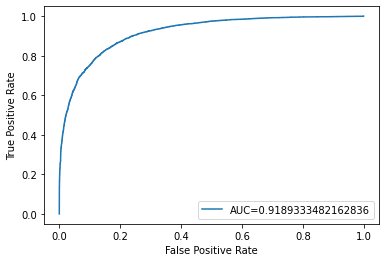

In [11]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(Y_test,  model.predict(X_test, verbose=0))
auc = metrics.roc_auc_score(Y_test, model.predict(X_test, verbose=0))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## HLS4ML Conversion

In [12]:
"""
now hls4ml conversion
"""
import hls4ml
config = hls4ml.utils.config_from_keras_model(model,
                                     default_precision="ap_fixed<32,12>",
                                     granularity='model'
)
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

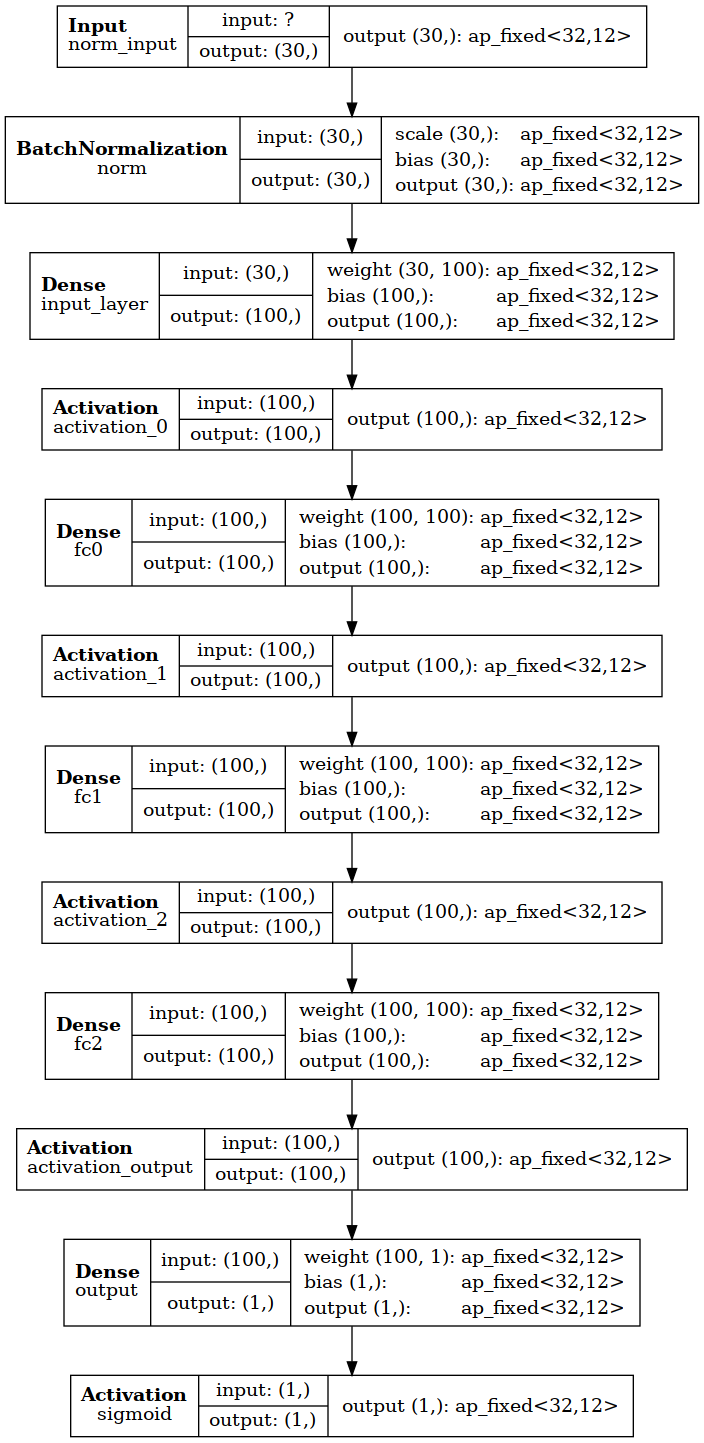

In [13]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [14]:
""" 
Before we run the hls model, we need to compile it
""" 
hls_model.compile()


Writing HLS project
Done


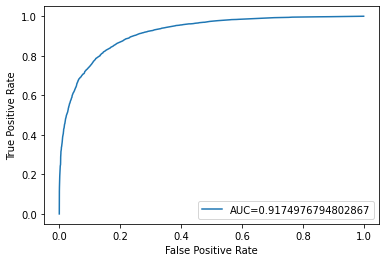

In [15]:
""" 
Now let's make the ROC cure. Note that X for hls model needs to be in 
"ascontiguousarray" format first
""" 
X_hls_test = np.ascontiguousarray(X_test)
fpr, tpr, _ = metrics.roc_curve(Y_test,  hls_model.predict(X_hls_test))
auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Post Training Quantization
Now this looks awesome, but let's see how little resources we can get away while not losing
performance

In [16]:
"""
Parameter search over integer bits. Fractional bits frozen at 20    
"""
fract_bit = 20
aurocs_int = []
ap_fixed_configs_int = []

for int_bit in range(2,32,4): # search from 2 to 32, with with 4 bit intervals
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_int.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

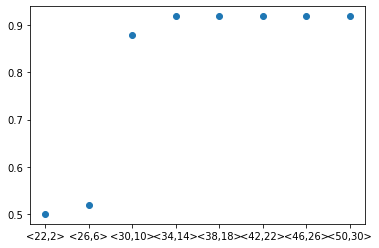

In [17]:
plt.scatter(ap_fixed_configs_int, aurocs_int)

Looks like we don't lose performance until integer bit width = 14.

In [21]:
"""
Parameter search over fractional bits. Integer bits frozen at 14    
"""
int_bit = 14
aurocs_fract = []
ap_fixed_configs_fract = []

for fract_bit in range(2,32,4):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract.append(auc)
    ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

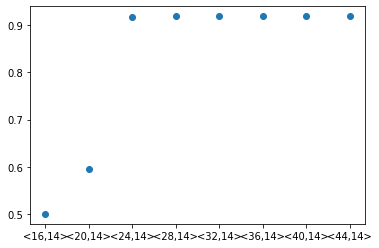

In [22]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract)

Looks like we don't lose performance until fractional bit width = 10.

## Quantization Aware Training + Pruning
taken from https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb
Oct 30 2022

Now, suppose we need our model to be faster and more light weight. Good thing is, lots of people have been researching this problem and we already have ready made tools to do this job very well. One of the more refined and available tools is called "AutoQKeras" from Google:

In [26]:
""" 
We do some setup before using AutoQKeras.
It's taken from their official tutorial, so you don't have 
to fully understand what's going on as long as you can 
validate the results.
"""

import json
import pprint
import numpy as np
import tempfile
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize
from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

reference_internal = "fp32"
reference_accumulator = "fp32"

q = run_qtools.QTools(
    model,
    # energy calculation using a given process
    # "horowitz" refers to 45nm process published at
    # M. Horowitz, "1.1 Computing's energy problem (and what we can do about
    # it), "2014 IEEE International Solid-State Circuits Conference Digest of
    # Technical Papers (ISSCC), San Francisco, CA, 2014, pp. 10-14, 
    # doi: 10.1109/ISSCC.2014.6757323.
    process="horowitz",
    # quantizers for model input
    source_quantizers=[quantized_bits(8, 0, 1)],
    is_inference=False,
    # absolute path (including filename) of the model weights
    # in the future, we will attempt to optimize the power model
    # by using weight information, although it can be used to further
    # optimize QBatchNormalization.
    weights_path=None,
    # keras_quantizer to quantize weight/bias in un-quantized keras layers
    keras_quantizer=reference_internal,
    # keras_quantizer to quantize MAC in un-quantized keras layers
    keras_accumulator=reference_accumulator,
    # whether calculate baseline energy
    for_reference=True)
  
# caculate energy of the derived data type map.
energy_dict = q.pe(
    # whether to store parameters in dram, sram, or fixed
    weights_on_memory="sram",
    # store activations in dram or sram
    activations_on_memory="sram",
    # minimum sram size in number of bits. Let's assume a 16MB SRAM.
    min_sram_size=8*16*1024*1024,
    # whether load data from dram to sram (consider sram as a cache
    # for dram. If false, we will assume data will be already in SRAM
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()
print("Total energy: {:.2f} uJ".format(total_energy / 1000000.0))

Instructions for updating:
Use ref() instead.
{'activation_0': {'energy': {'inputs': 190.19,
                             'op_cost': 0.0,
                             'outputs': 190.19,
                             'parameters': 0.0},
                  'total': 190.19},
 'activation_1': {'energy': {'inputs': 190.19,
                             'op_cost': 0.0,
                             'outputs': 190.19,
                             'parameters': 0.0},
                  'total': 190.19},
 'activation_2': {'energy': {'inputs': 190.19,
                             'op_cost': 0.0,
                             'outputs': 190.19,
                             'parameters': 0.0},
                  'total': 190.19},
 'activation_output': {'energy': {'inputs': 190.19,
                                  'op_cost': 0.0,
                                  'outputs': 190.19,
                                  'parameters': 0.0},
                       'total': 190.19},
 'fc0': {'energy': {'inputs':

In [27]:
"""
List of configs for AutoQKeras 
"""
quantization_config = {
        "kernel": {
                "binary": 1,
                "stochastic_binary": 1,
                "ternary": 2,
                "stochastic_ternary": 2,
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
                "quantized_po2(4,1)": 4
        },
        "bias": {
                "quantized_bits(4,0,1)": 4,
                "quantized_bits(8,3,1)": 8,
                "quantized_po2(4,8)": 4
        },
        "activation": {
                "binary": 1,
                "ternary": 2,
                "quantized_relu_po2(4,4)": 4,
                "quantized_relu(3,1)": 3,
                "quantized_relu(4,2)": 4,
                "quantized_relu(8,2)": 8,
                "quantized_relu(8,4)": 8,
                "quantized_relu(16,8)": 16
        },
        "linear": {
                "binary": 1,
                "ternary": 2,
                "quantized_bits(4,1)": 4,
                "quantized_bits(8,2)": 8,
                "quantized_bits(16,10)": 16
        }
}

limit = {
    "Dense": [8, 8, 4],
    "Activation": [4],
    "BatchNormalization": []
}
goal = {
    "type": "energy",
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["int8"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}


run_config = {
  "output_dir": tempfile.mkdtemp(),
  "goal": goal,
  "quantization_config": quantization_config,
  "learning_rate_optimizer": False,
  "transfer_weights": False,
  "mode": "random",
  "seed": 42,
  "limit": limit,
  "tune_filters": "layer",
  "tune_filters_exceptions": "^dense",
  # "distribution_strategy": cur_strategy,
  # first layer is input, layer two layers are softmax and flatten
  "layer_indexes": range(1, len(model.layers) - 1),
  "max_trials": 20
}

print("quantizing layers:", [model.layers[i].name for i in run_config["layer_indexes"]])

quantizing layers: ['input_layer', 'activation_0', 'fc0', 'activation_1', 'fc1', 'activation_2', 'fc2', 'activation_output', 'output']


In [28]:
"""
Now we let AutoQKeras do its magic and fine tune your model.
"""
custom_objects = {}
autoqk = AutoQKeras(model, metrics=["acc"], custom_objects=custom_objects, **run_config)
autoqk.fit(X_train, Y_train, validation_split=0.20, batch_size=128, epochs=20, verbose=0)

Limit configuration:{"Dense": [8, 8, 4], "Activation": [4], "BatchNormalization": []}
learning_rate: 0.0010000000474974513
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 100)               3100      
                                                                 
 activation_0 (QActivation)  (None, 100)               0         
                                                                 
 fc0 (QDense)                (None, 100)               10100     
                                                                 
 activation_1 (QActivation)  (None, 100)               0         
                                                                 
 fc1 (QDense)                (None, 100)               10100     

/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


learning_rate: 0.0010000000474974513
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 100)               3100      
                                                                 
 activation_0 (QActivation)  (None, 100)               0         
                                                                 
 fc0 (QDense)                (None, 150)               15150     
                                                                 
 activation_1 (QActivation)  (None, 150)               0         
                                                                 
 fc1 (QDense)                (None, 200)               30200     
                                                                 
 activation_2 (QAct

ValueError: in user code:

    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


The Cell above may give you an error when run. However, it should have done enough work for you to get the best model it has computed so far, and move on

In [29]:
qmodel = autoqk.get_best_model()


learning_rate: 0.0010000000474974513
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 50)                1550      
                                                                 
 activation_0 (QActivation)  (None, 50)                0         
                                                                 
 fc0 (QDense)                (None, 50)                2550      
                                                                 
 activation_1 (QActivation)  (None, 50)                0         
                                                                 
 fc1 (QDense)                (None, 50)                2550      
                                                                 
 activation_2 (QAct

The code above should give out a report, showing how much more light weight the function made your model to be.

To verify it ourselves, let's print the total number of trainable parameters for our model vs their qmodel.

In [30]:
import tensorflow.keras.backend as K

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
print(f"model number of trainable parameters: {trainable_count}")
trainable_count = np.sum([K.count_params(w) for w in qmodel.trainable_weights])
print(f"qmodel number of trainable parameters: {trainable_count}")

model number of trainable parameters: 33561
qmodel number of trainable parameters: 14511


If your case is anything like mine, your qmodel would be using less than half of the trainable parameters. Pretty amazing for a few lines of code!

Now let's do the integer and fractional bit searches again with the new model.
Unfortunately, hls4ml doesn't like AutoQKeras (not everything is supported). We may have to manually define a new model that fits 

To do this, I recommend printing the model's summary, read it and make the appropriate changes like this:

In [39]:
qmodel.predict(X_test, verbose = 0)
print(qmodel.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 norm (BatchNormalization)   (None, 30)                120       
                                                                 
 input_layer (QDense)        (None, 50)                1550      
                                                                 
 activation_0 (QActivation)  (None, 50)                0         
                                                                 
 fc0 (QDense)                (None, 50)                2550      
                                                                 
 activation_1 (QActivation)  (None, 50)                0         
                                                                 
 fc1 (QDense)                (None, 50)                2550      
                                                                 
 activation_2 (QActivation)  (None, 50)                0

The output should print out the # of nodes for each layer in the form of "Output Shape". Ignore the parameters for the activations and batchnormalization, since their shapes don't change.

Save the # of nodes, and use it to create a new model compatible with the new model generated from AutoQKeras. Before you do that however, we need to retrain the model, and save its weights.

In [36]:
""" 
We need to train it all over again
""" 
adam = Adam(lr=0.001)
qmodel.compile(optimizer=adam, loss=['binary_crossentropy'])

qmodel.fit(X_train, Y_train, batch_size=64,
            epochs=30, validation_split=0.20, shuffle=True, verbose=0
) # fit makes batchnorm to be in training mode

Epoch 1/30


/home/swissman777/anaconda3/envs/phys570/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


682/682 [==============================] - 4s 5ms/step - loss: 0.4731 - val_loss: 0.4169
Epoch 2/30
682/682 [==============================] - 3s 4ms/step - loss: 0.4175 - val_loss: 0.4218
Epoch 3/30
682/682 [==============================] - 3s 4ms/step - loss: 0.4102 - val_loss: 0.4022
Epoch 4/30
682/682 [==============================] - 3s 4ms/step - loss: 0.4029 - val_loss: 0.3922
Epoch 5/30
682/682 [==============================] - 3s 4ms/step - loss: 0.3989 - val_loss: 0.3919
Epoch 6/30
682/682 [==============================] - 3s 4ms/step - loss: 0.3917 - val_loss: 0.3856
Epoch 7/30
682/682 [==============================] - 3s 4ms/step - loss: 0.3932 - val_loss: 0.3900
Epoch 8/30
682/682 [==============================] - 3s 4ms/step - loss: 0.3923 - val_loss: 0.3820
Epoch 9/30
682/682 [==============================] - 3s 4ms/step - loss: 0.3931 - val_loss: 0.3821
Epoch 10/30
682/682 [==============================] - 3s 4ms/step - loss: 0.3882 - val_loss: 0.3810
Epoch 11/3

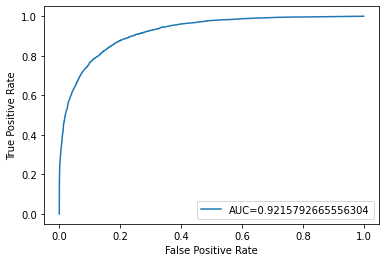

In [38]:
"""
Testing phase
"""
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, _ = metrics.roc_curve(Y_test,  qmodel.predict(X_test, verbose=0))
auc = metrics.roc_auc_score(Y_test, qmodel.predict(X_test, verbose=0))
  

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
qmodel.save_weights("qmodel.h5") # save weights in case you have to load it later

Now we define a new keras model and load the trained qmodel weights into it

In [32]:
""" 
Defining the new model. In my case, the input layer dimension was 50, 
and the hidden dimensions were 50,50,150
Those two are the only things that changes
""" 
input_dim = X_train.shape[-1]
input_layer_dim = 50 
hidden_dims = [50,50,150]
n_hidden_layers = 3




model = Sequential()
model.add(BatchNormalization(input_shape=(input_dim,), name='norm'))
model.add(Dense(input_layer_dim, name='input_layer', kernel_regularizer=l2(0.0001)))

for idx in range(n_hidden_layers): # hidden layers
    model.add(Activation(activation="relu", name=f'activation_{idx}'))
    model.add(Dense(hidden_dims[idx], name=f'fc{idx}', kernel_regularizer=l2(0.0001)))

model.add(Activation(activation="relu", name=f'activation_output'))
model.add(Dense(1, name='output', kernel_regularizer=l2(0.0001)))
model.add(Activation(activation='sigmoid', name='sigmoid'))


Now, load the saved qmodel weights and let's do the fractional searches again.

In [40]:
model.load_weights("qmodel.h5")

In [41]:
""" 
Integer bit search
""" 
"""
Parameter search over integer bits. Fractional bits frozen at 20    
"""
fract_bit = 20
aurocs_int_q = []
ap_fixed_configs_int = []

for int_bit in range(2,32,4): # search from 2 to 32, with with 4 bit intervals
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_int_q.append(auc)
    ap_fixed_configs_int.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done


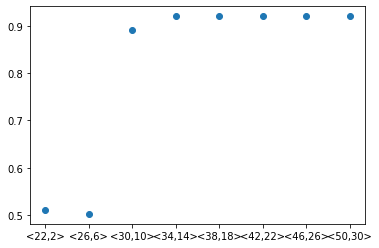

In [42]:
plt.scatter(ap_fixed_configs_int, aurocs_int_q)

seems integer bit = 14 is best

In [43]:
"""
Parameter search over fractional bits. Integer bits frozen at 14    
"""
int_bit = 14
aurocs_fract_q = []
ap_fixed_configs_fract = []

for fract_bit in range(2,32,4):
    total_bit = int_bit + fract_bit
    ap_fixed_config = f"ap_fixed<{total_bit},{int_bit}>"
    config = hls4ml.utils.config_from_keras_model(model,
                                        default_precision=ap_fixed_config,
                                        granularity='model'
    )
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                        hls_config=config,
                                                        output_dir='model_1/hls4ml_prj',
                                                        part='xcu250-figd2104-2L-e'
    )
    hls_model.compile()
    X_hls_test = np.ascontiguousarray(X_test)
    auc = metrics.roc_auc_score(Y_test, hls_model.predict(X_hls_test))
    aurocs_fract_q.append(auc)
    ap_fixed_configs_fract.append(f"<{total_bit},{int_bit}>")
    


Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], output sha

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: Input
Layer name: norm, layer type: BatchNormalization
Layer name: input_layer, layer type: Dense
  -> Activation (linear), layer name: input_layer
Layer name: activation_0, layer type: Activation
Layer name: fc0, layer type: Dense
  -> Activation (linear), layer name: fc0
Layer name: activation_1, layer type: Activation
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: activation_2, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: activation_output, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: norm_input, layer type: InputLayer, input shapes: [[None, 30]], output shape: [None, 30]
Layer name: norm, layer type: BatchNormalization, input shapes: [[None, 30]], outpu

Done


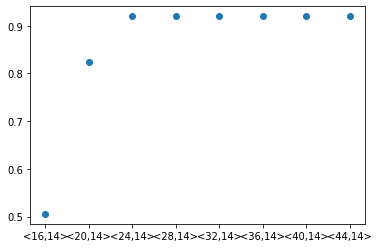

In [44]:
plt.scatter(ap_fixed_configs_fract, aurocs_fract_q)

Seems fractional bit = 10 is best


In my case, there wasn't really a benefit in Post Training Quantization with AutoQKeras, but the curves did decay a bit more slowly. Also, our bitwidth search wasn't very fine due to time constraints, so our results here aren't so conclusive. (HINT: if you make a finer search, you would most likely find a slightly better ap fixed values)

Maybe we would have seen better performance if we maintained quantized activations in hls4ml, but that's a task for another day.




Closing thoughts:
We have gone through a lot today. From implementing hls4ml, PTQ and AutoAKeras.

Hope this wasn't too overwhelming. I bet a lot of you aren't very comfortable with just buzzing through many different packages without fully understanding what's happening at the backend. 

But this is something we as researchers must get comfortable. We simply don't have the time to be comfortable with everything. Just learning enough to validate its operations and moving on is a important skill, and while it has its drawbacks, statistically, this is the way.